In [1]:
import gym
import numpy as np
import collections
import sys
from tqdm import tqdm
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import math
from Foraging_v0.envs.Foraging_env import ForagingEnv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/home/bobiko/workspace/rl/final-project/Foraging-v0/Foraging_v0/envs/Foraging_env.py:28: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax = mplot3d.Axes3D(self.fig)


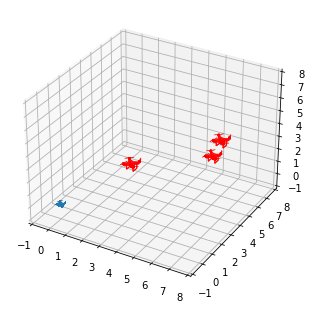

In [2]:
ep_len = 340

env = ForagingEnv(map_size=[7, 7, 7], fixed_goals=[[5, 7, 1], [3, 2, 3], [7, 4, 5]])
env._max_episode_steps = ep_len

In [3]:
observation = env.reset()
print(observation)
print(env.fixed_goals)

[array([2, 4, 4], dtype=int32), array([6, 3, 2], dtype=int32), array([4, 6, 3], dtype=int32)]
[[5, 7, 1], [3, 2, 3], [7, 4, 5]]


In [4]:
class actor_net(nn.Module):
    def __init__(self, inp_dim):
        super().__init__()
        
        self.inp_dim = inp_dim
        
        self.fc1 = nn.Linear(self.inp_dim, 4)
        self.fc2 = nn.Linear(4, 6)
        self.fc3 = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, inplace=False)
        x = self.fc2(x)
        x = F.leaky_relu(x, inplace=False)
        x = self.fc3(x)
        
        return x

In [5]:
class critic_net(nn.Module):
    def __init__(self, inp_dim):
        super().__init__()
        
        self.inp_dim = inp_dim
        
        self.fc1 = nn.Linear(self.inp_dim, 6)
        self.fc2 = nn.Linear(6, 2)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, inplace=False)
        x = self.fc2(x)
        x = F.leaky_relu(x, inplace=False)
        x = self.fc3(x)
        x = F.leaky_relu(x, inplace=False)
        
        return x

In [6]:
def run_q_net(q_net, observation, action, w):
        q_net.load_state_dict(w)
        if action:
            net_input = torch.tensor([observation[0], observation[1],
                                      observation[2], action[0]]).float()
        else:
            net_input = torch.tensor([observation[0], observation[1],
                                      observation[2]]).float()
        
        return q_net(net_input)

In [9]:
def loss_actor(idx, actor, actor_copy, critic, critic_copy, action, obs, a_weight, reward, gamma, l, next_obs, c_weight, agents):
    pi = []
    V = []
    V_next = []
    pi_t = []
    
    for a in agents:
        pi.append(run_q_net(actor[a], obs[a], False, a_weight[a]))
        V.append(run_q_net(critic[a], obs[a], False, c_weight[a]))
        V_next.append(run_q_net(critic_copy[a], next_obs[a], False, c_weight[a]))
   
    x = []
    k = []
 
       
    pi_max = torch.max(pi[idx])
    p = 0
    for t in agents:
        if t != idx:
            pi_t.append(torch.max(run_q_net(actor_copy[idx][t], obs[t], False, a_weight[idx])))
            
            if p == 0:
                x.append(pi_t[-1] / torch.max(pi[t]) * torch.log(pi_t[-1]) * (torch.tensor(reward[t]) + gamma * V_next[t] - V[t]))
                p = 1

            else:
                k.append(x[-1] + pi_t[-1] / torch.max(pi[t]) * torch.log(pi_t[-1]) * (torch.tensor(reward[t]) + gamma * V_next[t] - V[t]))        
    
    loss = - torch.log(pi_max) * (torch.tensor(reward[idx]) + gamma * V_next[idx] - V[idx]) - l * k[-1]
    return loss

In [10]:
def loss_critic (idx, actor, actor_copy, critic, critic_copy, action, obs, a_weight, reward, gamma, l, next_obs, c_weight, agents):
    pi = []
    V = []
    V_next = []
    y_t = []
    pi_t = []
    for a in agents:
        pi.append(run_q_net(actor[a], obs[a], False, a_weight[a]))
        V.append(run_q_net(critic[a], obs[a], False, c_weight[a]))
        V_next.append(run_q_net(critic_copy[a], next_obs[a], False, c_weight[a]))
        
    
    p = 0
    y_a = reward[idx] + gamma * V_next[idx]

    for t in agents:  
        if idx != t:
            y_t.append(reward[t] + gamma * V_next[t])
            pi_t.append(torch.max(run_q_net(actor_copy[idx][t], obs[t], False, a_weight[idx])))
            
            if p == 0:
                x = pi_t[-1] / torch.max(pi[t]) * (V[t] - y_t[-1]) ** 2
                p = 1
                
            else:
                S = x + pi_t[-1] / torch.max(pi[t]) * (V[t] - y_t[-1]) ** 2

    loss = - (V[idx] - y_a) ** 2 - l * S
        
    return loss

In [13]:
def SEAC(env, update_params, visualize = False):
    observation = env.reset()
    
    agents = [0, 1, 2]
   

    PG_updates_num = 1
    episodes_num   = 30
    episode_length = 70
    
    alpha = 0.1
    l = 0.4
    gamma = 0.7
    
    obs = env.reset()
    
    obs_history = [[0], [0], [0]]
    
    
    a_loss_history = [[0], [0], [0]]
    c_loss_history = [[0], [0], [0]]
    
    Q_history = []
    reward_history = [[0], [0], [0]]
    
    a_weight = []
    c_weight = []
    
    actor = []
    critic = []
    critic_copy = []
    
    
    a_optimizer = []
    c_optimizer = []
        
    observation_dim, action_dim = 3, 6
    
    for a in agents:
        actor.append(actor_net(observation_dim))
        critic.append(critic_net(observation_dim))
        critic_copy.append(critic_net(observation_dim))
        
        a_optimizer.append(torch.optim.Adam(actor[a].parameters(), lr=alpha))
        c_optimizer.append(torch.optim.Adam(critic[a].parameters(), lr=alpha))
        
    actor_copy = [[actor_net(observation_dim), actor_net(observation_dim), actor_net(observation_dim)],
                  [actor_net(observation_dim), actor_net(observation_dim), actor_net(observation_dim)],
                  [actor_net(observation_dim), actor_net(observation_dim), actor_net(observation_dim)]]
    

    
    action = [0, 0, 0]

    
    start_state = env.state
    print(start_state)
    
    for a in agents:
        a_weight.append(actor[a].state_dict())
        c_weight.append(critic[a].state_dict())
    
    for PG_step in range(PG_updates_num):
        skip_loss_calculation = True
        
        for ep in range(episodes_num):
            
            print('-------------------')
            print('ep_num ', ep)
            env.state = start_state
            
            for time_step in range(episode_length):
                
               
                if (visualize == True):
                    env.render()
                for a in agents:                
                    action[a] = torch.argmax(run_q_net(actor[a], obs[a], False, a_weight[a]))
                    m = [int(obs[a][0]), int(obs[a][1]), int(obs[a][2])]
                    if m == env.fixed_goals[0] or m == env.fixed_goals[1] or m == env.fixed_goals[2]:
                        action[a] = 6

                
                next_obs, reward, done, smth = env.step(action)
                
#                 if done:
#                     break
                for a in agents:
                    m = [int(next_obs[a][0]), int(next_obs[a][1]), int(next_obs[a][2])]
                    obs_history[a].append(m)
                    if m == env.fixed_goals[0] or m == env.fixed_goals[1] or m == env.fixed_goals[2]:
                        reward[a] = 0
                        done[a] = True
                        
                    reward_history[a].append(reward[a])
                    
                print( next_obs, done)
                

                if (not skip_loss_calculation):
                    for a in agents:
                        a_optimizer[a].zero_grad() 
                        c_optimizer[a].zero_grad()
                        
                        loss = loss_actor(a, actor, actor_copy, critic, critic_copy, action, obs, a_weight, reward, gamma, l, next_obs, c_weight, agents)
                        loss.backward()
                        a_optimizer[a].step()
                        a_weight[a] = actor[a].state_dict()
                        a_loss_history[a].append(loss)
        
                        loss = loss_critic (a, actor, actor_copy, critic, critic_copy, action, obs, a_weight, reward, gamma, l, next_obs, c_weight, agents)
                        loss.backward()
                        c_optimizer[a].step()
                        c_weight[a] = critic[a].state_dict()
                        c_loss_history[a].append(loss)
            
                else:
                    skip_loss_calculation = False
                
#                 time.sleep(0.01)
                    
                obs = next_obs
    
    return reward_history, a_loss_history, c_loss_history, obs_history

In [14]:
SEAC_reward_history, a_loss_history, c_loss_history, obs_history = SEAC(env, update_params = True, visualize = False)


env.close()

[array([5, 2, 0], dtype=int32), array([3, 0, 4], dtype=int32), array([6, 2, 4], dtype=int32)]
-------------------
ep_num  0
[array([6, 2, 0], dtype=int32), array([3, 0, 3], dtype=int32), array([5, 2, 4], dtype=int32)] [False, False, False]
[array([7, 2, 0], dtype=int32), array([3, 0, 2], dtype=int32), array([4, 2, 4], dtype=int32)] [False, False, False]
[array([6, 2, 0], dtype=int32), array([3, 1, 2], dtype=int32), array([4, 1, 4], dtype=int32)] [False, False, False]
[array([6, 2, 1], dtype=int32), array([3, 1, 3], dtype=int32), array([5, 1, 4], dtype=int32)] [False, False, False]
[array([6, 2, 2], dtype=int32), array([3, 2, 3], dtype=int32), array([6, 1, 4], dtype=int32)] [False, True, False]
[array([6, 2, 3], dtype=int32), array([3, 2, 3], dtype=int32), array([6, 1, 3], dtype=int32)] [False, True, False]
[array([6, 2, 2], dtype=int32), array([3, 2, 3], dtype=int32), array([6, 2, 3], dtype=int32)] [False, True, False]
[array([6, 2, 1], dtype=int32), array([3, 2, 3], dtype=int32), arra

/home/bobiko/.envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


[array([6, 2, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([6, 4, 5], dtype=int32)] [False, True, False]
[array([6, 2, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([6, 4, 6], dtype=int32)] [False, True, False]
[array([6, 1, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([5, 4, 6], dtype=int32)] [False, True, False]
[array([6, 0, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([4, 4, 6], dtype=int32)] [False, True, False]
[array([6, 0, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([3, 4, 6], dtype=int32)] [False, True, False]
[array([6, 0, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([2, 4, 6], dtype=int32)] [False, True, False]
[array([6, 0, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([2, 4, 7], dtype=int32)] [False, True, False]
[array([6, 0, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([2, 4, 7], dtype=int32)] [False, True, False]
[array([6, 1, 0], dtype=int32), array([3, 2, 3], dtype=int32), array([2, 3, 7], 

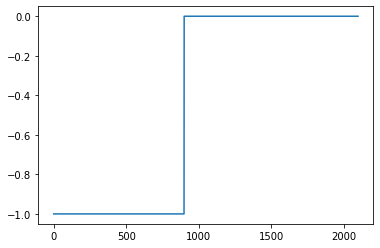

In [15]:
plt.plot(SEAC_reward_history[0][1:])

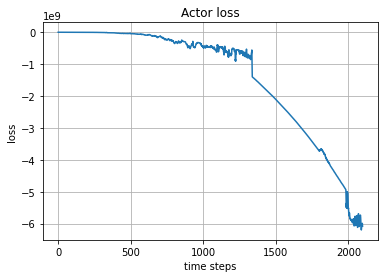

In [16]:
plt.plot(a_loss_history[0][1:])
plt.title("Actor loss")
plt.xlabel("time steps")
plt.ylabel("loss");
plt.grid(True)
plt.savefig('actor_loss.png')

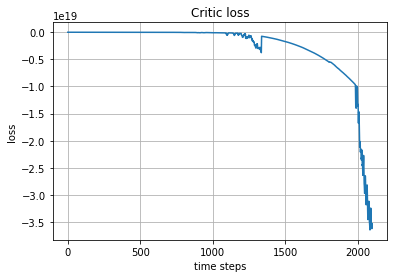

In [17]:
plt.plot(c_loss_history[0][1:])
plt.title("Critic loss")
plt.xlabel("time steps")
plt.ylabel("loss");
plt.grid(True)
plt.savefig('critic_loss.png')

In [14]:
import json
with open('data.txt', 'w') as outfile:
     json.dump(obs_history, outfile, sort_keys = True, indent = 4,
               ensure_ascii = False)

In [18]:
arr = []
for obs in obs_history:
    arr.append(obs[1:])
print(arr)

[[[6, 2, 0], [7, 2, 0], [6, 2, 0], [6, 2, 1], [6, 2, 2], [6, 2, 3], [6, 2, 2], [6, 2, 1], [6, 2, 0], [6, 2, 0], [6, 2, 0], [6, 2, 0], [6, 1, 0], [6, 0, 0], [6, 0, 0], [6, 0, 0], [6, 0, 0], [6, 0, 0], [6, 1, 0], [6, 2, 0], [6, 3, 0], [6, 4, 0], [6, 4, 1], [6, 4, 2], [6, 4, 3], [6, 4, 2], [6, 3, 2], [6, 2, 2], [6, 2, 1], [6, 2, 0], [6, 3, 0], [6, 4, 0], [6, 4, 1], [6, 3, 1], [6, 3, 2], [6, 2, 2], [6, 2, 1], [6, 3, 1], [6, 3, 2], [6, 3, 3], [6, 3, 2], [6, 2, 2], [6, 1, 2], [6, 1, 1], [6, 1, 2], [6, 1, 3], [6, 2, 3], [6, 2, 2], [6, 3, 2], [6, 2, 2], [6, 1, 2], [6, 1, 1], [6, 1, 2], [6, 1, 3], [6, 1, 4], [5, 1, 4], [6, 1, 4], [7, 1, 4], [7, 1, 4], [6, 1, 4], [5, 1, 4], [4, 1, 4], [4, 2, 4], [4, 3, 4], [4, 4, 4], [5, 4, 4], [5, 5, 4], [5, 6, 4], [5, 7, 4], [5, 7, 4], [5, 7, 4], [4, 7, 4], [3, 7, 4], [3, 7, 5], [3, 7, 6], [3, 7, 5], [3, 7, 4], [3, 7, 3], [4, 7, 3], [5, 7, 3], [6, 7, 3], [6, 6, 3], [5, 6, 3], [4, 6, 3], [4, 6, 4], [4, 6, 3], [4, 6, 2], [4, 6, 1], [4, 6, 0], [4, 7, 0], [4, 7, 0

In [19]:
np.save('traj.npy', arr)

In [ ]:
plt.plot(c_loss_history[1][1:])

In [18]:
s = np.load('traj.npy')

In [19]:
print(s)

[[[2 1 0]
  [3 1 0]
  [2 1 0]
  ...
  [3 2 3]
  [3 2 3]
  [3 2 3]]

 [[5 0 5]
  [5 0 5]
  [6 0 5]
  ...
  [7 4 5]
  [7 4 5]
  [7 4 5]]

 [[3 6 4]
  [4 6 4]
  [5 6 4]
  ...
  [5 7 1]
  [5 7 1]
  [5 7 1]]]
